<span style="font-size: 40px;">HW4-3: Enhance DQN for random mode WITH Training Tips</span>

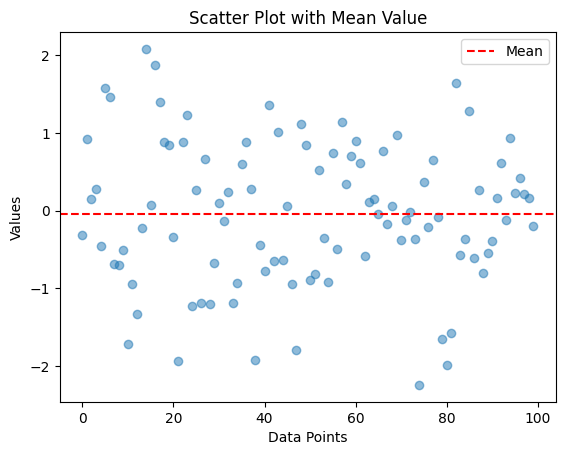

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(100)

# Calculate the mean value
mean_value = np.mean(data)

# Plot the data with alpha level
plt.scatter(range(len(data)), data, alpha=0.5)

# Add a horizontal line for the mean value
plt.axhline(mean_value, color='red', linestyle='--', label='Mean')

# Set plot properties
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Scatter Plot with Mean Value')
plt.legend()

# Display the plot
plt.show()

In [2]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [3]:
#使用GPU
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # 如果是 GPU 版應該會顯示 True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

2.7.0+cu118
True
Using device: cuda


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape 
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
).to(device)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

In [ ]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float().to(device)
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.cpu().data.numpy()
      action_ = np.argmax(qval_) 
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float().to(device)
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 10): #若移動了10步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break    
    win = True if status == 2 else False
    print(win)
    return win

<span style="font-size: 36px;">Double DQN for random mode(PyTorch Lightning) with training techniques</span>

In [ ]:
# 假設 Gridworld 類別已經定義好
class Gridworld:
    def __init__(self, size=4, mode='static'):
        self.size = size
        self.mode = mode
        self.board = self.create_board()

    def create_board(self):
        return np.zeros((self.size, self.size))

    def render_np(self):
        return self.board.flatten()

    def reward(self):
        return random.choice([-1, 0, 10])

    def makeMove(self, action):
        pass

    def display(self):
        return str(self.board)


# 定義 QNet 模型
def create_q_model():
    model = Sequential()
    model.add(Dense(128, input_dim=64, activation='relu'))
    model.add(Dense(4))  # 假設有 4 個動作
    model.compile(optimizer=Adam(lr=0.001), loss='mse')
    return model

# 初始化主網路與目標網路
model = create_q_model()
target_model = create_q_model()

# 目標網路初始化為主網路的權重
target_model.set_weights(model.get_weights())

# Double DQN 核心邏輯
def train_model(epochs=3000, sync_interval=20):
    losses = []
    epsilon = 1.0
    gamma = 0.9

    for i in range(epochs):
        game = Gridworld(size=4, mode='static')
        state_ = game.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state1 = tf.convert_to_tensor(state_, dtype=tf.float32)

        status = 1
        while status == 1:
            qval = model(state1)
            qval_ = qval.numpy()

            if random.random() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)

            action = action_set[action_]  # 假設 action_set 已定義
            game.makeMove(action)
            state2_ = game.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
            state2 = tf.convert_to_tensor(state2_, dtype=tf.float32)
            reward = game.reward()

            # Double DQN 核心邏輯：
            next_qvals = model(state2)
            next_action = tf.argmax(next_qvals, axis=1).numpy()[0]
            target_qvals = target_model(state2)
            maxQ = target_qvals[0, next_action]

            if reward == -1:
                Y = reward + gamma * maxQ
            else:
                Y = reward

            # 更新模型
            with tf.GradientTape() as tape:
                qval = model(state1)
                X = qval[0, action_]
                loss = K.mean(K.square(X - Y))

            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            state1 = state2
            if abs(reward) == 10:
                status = 0

        losses.append(loss.numpy())

        # 更新 epsilon
        if epsilon > 0.1:
            epsilon -= (1 / epochs)

        # 每隔 sync_interval 回合，同步一次 target_model
        if i % sync_interval == 0:
            target_model.set_weights(model.get_weights())

        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {loss.numpy():.4f}")

    # 畫出 Loss 曲線
    plt.figure(figsize=(10, 7))
    plt.plot(losses)
    plt.xlabel("Epochs", fontsize=11)
    plt.ylabel("Loss", fontsize=11)
    plt.title("Double DQN Loss")
    plt.show()

# 訓練模型
train_model(epochs=3000, sync_interval=20)


TypeError: __init__() got an unexpected keyword argument 'gpus'

In [ ]:
max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random') #模式測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' '-' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [

<span style="font-size: 36px;">Dueling DQN for random mode(PyTorch Lightning) with training techniques</span>